# 02477 Exercise 3: Bayesian Linear regression

In [1]:
%matplotlib inline
import jax.numpy as jnp
from jax import value_and_grad
from jax import grad
from jax import random
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as snb
from scipy.stats import multivariate_normal

snb.set_theme(font_scale=1.25)

- Rev. 3.0, 22/11-24

### Overview

The purpose of this exercise is to become familiar with Bayesian linear regression and reinforce the basic concepts of Bayesian inference. 
In the exercise, you will implement several parts of Bayesian linear regression pipeline. However, remember that the purpose of the exercise is to study and understand the key equations for Bayesian linear regression as well as to learn how to use them. 
Besides being useful for practical purposes, the code also allows you to build intuition, e.g. by investigating what happens when you change different parameters etc. So think of the code as a tool for understanding the models and their key equations and not only as an end-product.
_____

**Content**

- Part 1: Visualizing the prior, likelihood and posterior
- Part 2: Implementing the posterior distribution
- Part 3: The posterior predictive distribution
- Part 4: Modelling the number of Airline passengers
____





### Bayesian linear regression

Linear regression is perhaps the most common technique in applied statistics and machine learning for modelling the relationship between set of a covariates $\left\lbrace \mathbf{x}_n \right\rbrace_{n=1}^N$ and a response variable $\left\lbrace y_n \right\rbrace_{n=1}^N$. Rather than modelling the relationship between $\mathbf{x}_n$ and $y_n$ directly, we often apply a transformation $\phi$ to the input vectors $\mathbf{x}_n$ first. That is, we often use $\mathbf{\phi}_n = \mathbf{\phi}(\mathbf{x}_n)$ as input to regression model rather than $\mathbf{x}_n$ directly:

\begin{align*}
y_n = f(\mathbf{x}_n) + e_n = \phi(\mathbf{x}_n)^T \mathbf{w} + e_n = \mathbf{\phi}_n^T \mathbf{w} + e_n,
\end{align*}

where $f(\mathbf{x_n}) \equiv \mathbf{\phi}_n^T \mathbf{w}$.


More generally, let $\mathbf{\Phi} \in \mathbb{R}^{N \times D}$ be a **design matrix** and let  $\mathbf{y} \in \mathbb{R}^N$ be the response variables, then the linear regression model is given by

\begin{align*}
\mathbf{y}= \mathbf{\Phi}\mathbf{w} + \mathbf{e},
\end{align*}


where $\mathbf{w} \in \mathbb{R}^D$ is the regression weights and $\mathbf{e} \in \mathbb{R}^N$ is a noise vector. In this exercise, we will only look at additive isotropic Gaussian noise models, i.e. $e_n \sim \mathcal{N}(0, \sigma^2)$, but later we will study more general set-ups. 
___

> Recall, the **maximum likelihood estimator** of the weights $\mathbf{w}$ is given by

\begin{align*}
\hat{\mathbf{w}}_{\text{MLE}} = \left(\mathbf{\Phi}^T \mathbf{\Phi}\right)^{-1} \mathbf{\Phi}^T \mathbf{y}
\end{align*}

___

#### Bayesian Treatment 

We will now turn to the Bayesian treatment. Assuming isotropic Gaussian noise and imposing a multivariate Gaussian prior on $\mathbf{w} \sim \mathcal{N}\left(\mathbf{m}_0, \mathbf{S}_0\right)$ gives rise to the following joint distribution

\begin{align*}
p(\mathbf{y}, \mathbf{w}) = p\left(\mathbf{y}|\mathbf{w}\right)p\left(\mathbf{w}\right) = \mathcal{N}\left(\mathbf{y}\big|\mathbf{\Phi}\mathbf{w}, \sigma^2\mathbf{I}\right)\mathcal{N}\left(\mathbf{w}\big|\mathbf{m}_0, \mathbf{S}_0\right),
\end{align*}

where $\sigma^2$ is the noise variance. We will follow Bishop's notation and use the **noise precision** $\beta = \frac{1}{\sigma^2}$ to parametrize the noise variance.

____

#### The posterior distribution 

In contrast to the model we worked with last week, this model is an example of a **conjugate** model, meaning that the posterior distribution will also be a Gaussian distribution given by:

\begin{align*}
p(\mathbf{w}|\mathbf{y}) = \mathcal{N}(\mathbf{w}|\mathbf{m}, \mathbf{S})
\end{align*}

where the posterior covariance is given by
\begin{align*}
    \mathbf{S} &= \left(\mathbf{S}_0^{-1} + \beta \mathbf{\Phi}^T\mathbf{\Phi}\right)^{-1}\tag{1}
\end{align*}
and the posterior mean
\begin{align*}
\mathbf{m} &= \beta \mathbf{S}\mathbf{\Phi}^T\mathbf{y}.  \tag{2}
\end{align*}

##### In Python: 
- y is the vector of target observations 
  - shape (N,) or (N, 1) with broadcasting, where N is the number of observations
  - The target observations are the values we want to predict or model.
- Φ is the design matrix (basis function matrix) 
  - shape (N, M), where N is the number of data points and M is the number of basis functions (parameters).
  - The design matrix is constructed by applying the basis function to each data point in the input space.
  - 
  - In python it is done in a following way: 
   ```python
    def design_matrix(X, basis_function):
         return np.array([basis_function(x) for x in X])
    ```
- β is the precision (inverse variance) of the likelihood noise
  - shape (1, 1) or (1,) with broadcasting, where 1 is the number of features. 
- S0 is the prior covariance matrix for the weights w 
  - shape (M, M), where M is the number of basis functions (parameters).
  - The prior covariance matrix is a square matrix that describes the uncertainty in the prior distribution of the weights.
  - In python it is done in a following way: 
   ```python
    def prior_covariance_matrix(S0, M):
         return np.eye(M) * S0
    ```
- w is the weight vector (shape (M,) or (M, 1)).
  - The weight vector is the set of parameters we want to learn from the data.
- m is the posterior mean vector (shape (M,) or (M, 1)).
  - The posterior mean vector is the expected value of the weights given the data and the prior distribution.
  - In python it is done in a following way: 
   ```python
    def posterior_mean(S, beta, Phi, y):
         return beta * S @ Phi.T @ y
    ```
- S is the posterior covariance matrix (shape (M, M)).
 - The posterior covariance matrix is a square matrix that describes the uncertainty in the posterior distribution of the weights.
 - In python it is done in a following way: 
   ```python
    def posterior_covariance(S0, beta, Phi):
         return np.linalg.inv(np.linalg.inv(S0) + beta * Phi.T @ Phi)
    ``` 

> The **posterior distribution** $p(\mathbf{w}|\mathbf{y})$ quantifies our knowledge of the parameter after having observed the data $\mathbf{y}$. Hence, we can use the posterior distribution to reason about the size of the coefficients in the linear model. For example, we can use the posterior mean as an estimator of the coefficients and the posterior variance to quantify the uncertainty. 
____
#### The posterior predictive distribution

The posterior distribution also plays a crucial role when computing the **posterior predictive distribution**

$$\begin{align*}
p(y^*|\mathbf{y}, \mathbf{x}^*) &= \int p(y^*|\mathbf{x}^*, \mathbf{w})p(\mathbf{w}|\mathbf{y})\text{d}\mathbf{w} = \int \mathcal{N}(y^*|\phi^T_n \mathbf{w}, \beta^{-1}) \mathcal{N}(\mathbf{w}|\mathbf{m}, \mathbf{S}) \text{d}\mathbf{w}
= \mathcal{N}(y_*|\phi_*^T\mathbf{m}, \phi_*^T\mathbf{S} \phi_* + \beta^{-1}),
\end{align*}
$$

which we will dive deeper into later in the exercise.

____



First, we will look at the following a simple model:
\begin{align*}
y_n = a + bx_n +  e_n = \begin{bmatrix}1&x_n\end{bmatrix}\begin{bmatrix}a\\b\end{bmatrix} + e_n = \mathbf{\phi}_n^T \mathbf{w} + e_n.
\end{align*}

That is, $\mathbf{w} = \begin{bmatrix}a \\ b \end{bmatrix}$, where $a$ and $b$ are the intercept and slope of the line, respectively, and $\phi(x_n) = \begin{bmatrix}1 \\ x_n \end{bmatrix}$. Furthermore, we will assume a zero-mean and isotropic Gaussian prior, i.e. $\mathbf{m}_0 = \mathbf{0}$, $\mathbf{S}_0 = \alpha^{-1}\mathbf{I}$,



### Part 1:  Visualizing the prior, likelihood and posterior

First, we will work with the following toy dataset with $N = 20$ data points:

X-train shape (20, 1)


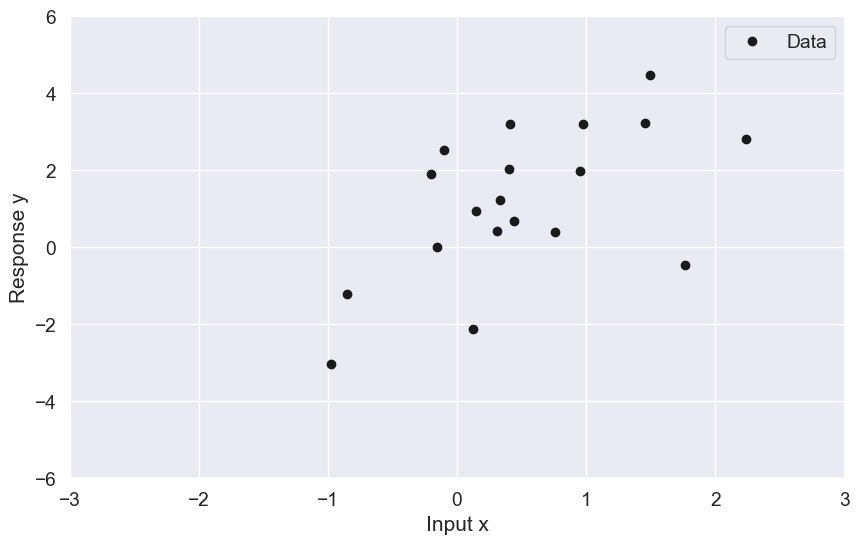

In [2]:
# Number of training samples
N = 20

# Create training input data as a 1D array and then reshape to a column vector (shape: [20, 1])
# The slicing "[:, None]" adds an extra axis so that xtrain becomes of shape (20,1).
# This is useful for broadcasting operations later on, for example when adding a bias term.
xtrain = jnp.array([1.764, 0.4, 0.979, 2.241, 1.868, -0.977,  0.95, -0.151, -0.103, 0.411,
                    0.144, 1.454, 0.761, 0.122, 0.444, 0.334, 1.494, -0.205, 0.313, -0.854])[:, None]
print(f"X-train shape {xtrain.shape}")

# Create training output data as a 1D array and reshape to a column vector (shape: [20, 1])
# The "[:, None]" similarly converts the array into a column vector.
ytrain = jnp.array([-0.464, 2.024, 3.191, 2.812, 6.512, -3.022, 1.99, 0.009, 2.513, 3.194,
                    0.935, 3.216, 0.386, -2.118, 0.674, 1.222, 4.481, 1.893, 0.422, -1.209])[:, None]

# Define a function to plot the toy dataset.
def plot_toydata(ax):
    # When plotting, broadcasting allows the function to handle the arrays even if their dimensions
    # are not immediately matching. Here, xtrain (shape: [20,1]) and ytrain (shape: [20,1]) are automatically
    # squeezed to 1D arrays if needed by the plotting function.
    ax.plot(xtrain, ytrain, 'k.', label='Data', markersize=12)
    ax.set(xlabel='Input x', ylabel='Response y', xlim=(-3, 3), ylim=(-6, 6))
    ax.legend()

# Create a matplotlib figure and axes, then plot the toy data.
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_toydata(ax)

The purpose of this part is to understand the basic building blocks of the linear model and reinforce the concepts of prior, likelihood, and posterior. First, we will define a convenient function for evaluating and plotting distributions using densities.

In [3]:
def plot_distribution(ax, x, y, density_fun, color=None, visibility=1, label=None, title=None, num_points = 100):
    
    # create grid for parameters (a,b)
    a_array = jnp.linspace(-4, 4, num_points)
    b_array = jnp.linspace(-4, 4, num_points)
    A_array, B_array = jnp.meshgrid(a_array, b_array)   
    
    # form array with all combinations of (a,b) in our grid
    AB = jnp.column_stack((A_array.ravel(), B_array.ravel()))
    
    # evaluate density for every point in the grid and reshape bac
    Z = density_fun(x, y, A_array.ravel(), B_array.ravel())
    Z = Z.reshape((len(a_array), len(b_array)))
    
    # plot contour  
    ax.contour(a_array, b_array, jnp.exp(Z), colors=color, alpha=visibility)
    ax.plot([-1000], [-1000], color=color, label=label)
    ax.set(xlabel='slope', ylabel='intercept', xlim=(-4, 4), ylim=(-4, 4), title=title)

Then we will implement the prior, likelihood and posterior densities:

lambda: 6.666666666666667
alpha or tau: 5 / beta or sigma: 0.75
MAP parameters: [0.5440742 1.2426339]


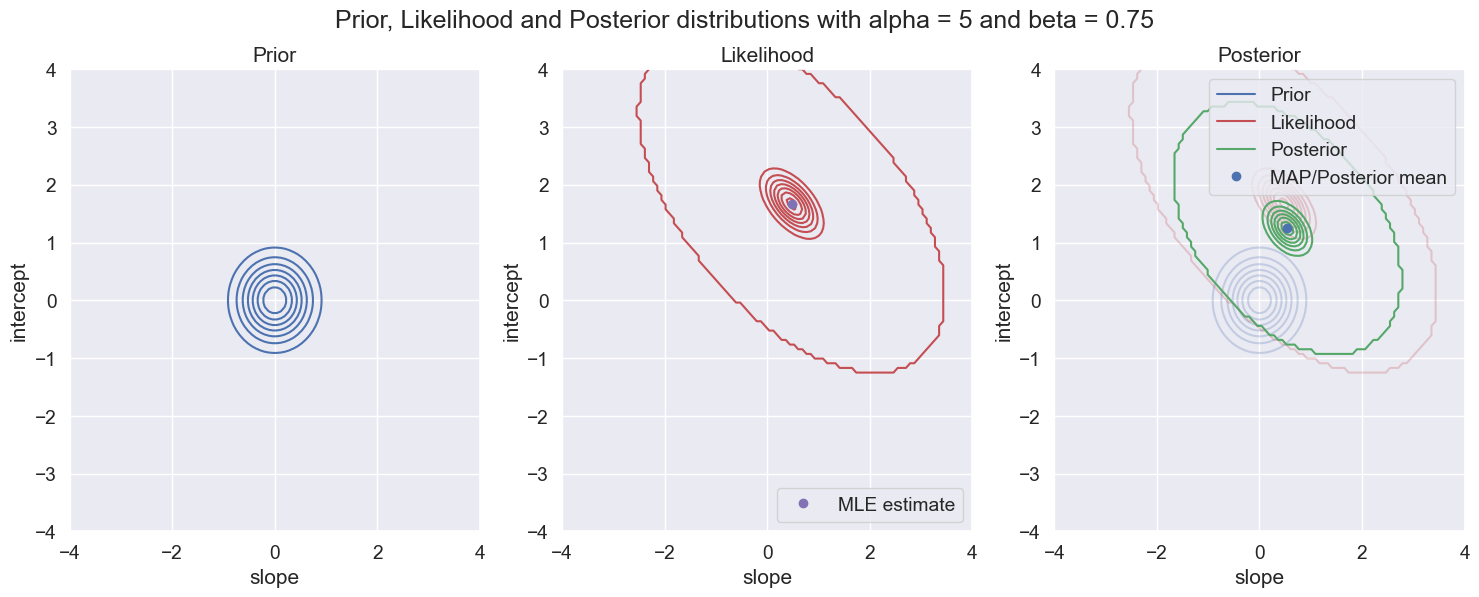

In [4]:
# ------------------------ START SELECTION_PLACEHOLDER ------------------------
# Set hyperparameters:
# A larger alpha means a tighter prior on your parameters (likely around 0)
# A larger beta means less noise in the data so the data are more reliable
alpha = 5      # sigma      # Prior precision: controls the spread (variance = 1/alpha) of the prior distribution over parameters.
beta = 3/4    # tau       # Likelihood precision: controls the noise level (variance = 1/beta) in the observation model.

# Define a lambda function to compute the log probability density of a normal distribution.
# This function computes: log N(x|m, v) = -0.5*log(2*pi*v) - 0.5*((x-m)^2)/v.
log_npdf = lambda x, m, v: -0.5 * jnp.log(2 * jnp.pi * v) - 0.5 * ((x - m)**2) / v 

# Define a simple linear prediction function:
# Given input x and parameters a (intercept) and b (slope), returns a + b*x.
predict = lambda x, a, b: a + b * x

def log_prior(x, y, a, b):
    """
    Computes the log prior probability of the parameters a and b.
    We assume a zero-mean isotropic Gaussian prior over the parameters with covariance 1/alpha * I.
    
    Parameters:
        x, y : Training data (not used here but kept for interface consistency)
        a, b : Parameters (intercept and slope)
    
    Returns:
        Log probability of the parameters under the prior.
    """
    # jnp.column_stack([a, b]) creates the parameter vector.
    # multivariate_normal.logpdf evaluates the log PDF of a multivariate Gaussian.
    return multivariate_normal.logpdf(jnp.column_stack([a, b]), jnp.array([0, 0]), 1/alpha * jnp.identity(2))

def log_likelihood(x, y, a, b):
    """
    Computes the total log likelihood of the observed data (x, y) given parameters a and b.
    The model predicts y = a + b*x with Gaussian noise of variance 1/beta.
    
    Parameters:
        x : Input features.
        y : Observed outputs.
        a, b : Model parameters.
    
    Returns:
        The sum of log likelihoods over all data points.
    """
    # predict(x, a, b) provides the mean prediction.
    # The variance of the likelihood is 1/beta.
    return jnp.sum(log_npdf(y, predict(x, a, b), 1/beta), 0)

def log_posterior(x, y, a, b):
    """
    Computes the log posterior for parameters a and b given data (x, y) by summing
    the log prior and the log likelihood.
    
    Parameters:
        x, y : Data.
        a, b : Parameters.
    
    Returns:
        Log posterior value.
    """
    return log_prior(x, y, a, b) + log_likelihood(x, y, a, b)

def design_matrix(x):
    """
    Constructs the design matrix for linear regression.
    For input vector x, returns a matrix with a column of ones (for the intercept)
    and a column with the actual x values.
    
    Parameters:
        x : Input data vector.
    
    Returns:
        Design matrix of shape (len(x), 2)
    """
    return jnp.column_stack((jnp.ones(len(x)), x))

# Create a figure with 3 subplots to visualize the prior, likelihood and posterior distributions.
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
# set a common title 
fig.suptitle(f'Prior, Likelihood and Posterior distributions with alpha = {alpha} and beta = {beta}')
# Plot prior: shows the belief about parameters before seeing the data.
plot_distribution(axes[0], xtrain, ytrain, density_fun=log_prior, color='b', title='Prior')
# Plot likelihood: shows how likely the observed data are for different parameter settings.
plot_distribution(axes[1], xtrain, ytrain, density_fun=log_likelihood, color='r', title='Likelihood')
# Plot posterior: overlay prior and likelihood (with reduced visibility) and plot the resulting posterior.
plot_distribution(axes[2], xtrain, ytrain, density_fun=log_prior, color='b', visibility=0.25, label='Prior')
plot_distribution(axes[2], xtrain, ytrain, density_fun=log_likelihood, color='r', visibility=0.25, label='Likelihood')
plot_distribution(axes[2], xtrain, ytrain, density_fun=log_posterior, color='g', label='Posterior', title='Posterior')
# ------------------------- END SELECTION_PLACEHOLDER -------------------------


################################################################################################################################
# Insert your solution here
################################################################################################################################

# Compute the design matrix for the training data,
# which adds a column of ones to xtrain to account for the intercept term.
design_matrix_ = design_matrix(xtrain)

# Compute the maximum likelihood solution by solving the normal equations:
# (X^T * X) * theta = X^T * y
# where theta contains the intercept and slope.
# ravel() is used to convert the result to a 1D array.
w_MLE = jnp.linalg.solve(design_matrix_.T @ design_matrix_, design_matrix_.T @ ytrain).ravel()

# Print the estimated parameters (intercept and slope).
#print(w_MLE)

########################################### 

# Compute the MAP (Maximum A Posteriori) estimate by summing the log prior and log likelihood.
# Note: In this context, MAP is computed in the log domain.
# lambda is the regularization parameter derived from the prior precision.
lambda_ = alpha / beta
print(f"lambda: {lambda_}")
# print alpha and beta and they are sometimes also called tau and sigma 
print(f"alpha or tau: {alpha} / beta or sigma: {beta}")


# beta stands for the likelihood precision, which controls the noise level in the observation model.
# alpha is the prior precision, which determines the spread of the prior distribution over parameters.

# Compute the MAP estimate by solving the modified normal equations.
# Here, lambda_ acts as the regularization parameter derived from the prior precision.
# w_map = (X^T * X + lambda * I)^-1 * X^T * y
# from murphy eq 11.57

w_MAP = jnp.linalg.solve(
    design_matrix_.T @ design_matrix_ + lambda_ * jnp.eye(design_matrix_.shape[1]),  # Regularized design matrix
    design_matrix_.T @ ytrain                                                    # Right-hand side from the data
).ravel()
# print the map parameters
print(f"MAP parameters: {w_MAP}")


##################################################################
# end of solution
##################################################################

# Add legends to the likelihood and posterior plots for clarity.
# plot the map and mle estimates
#axes[2].plot(MAP[0], MAP[1], 'black', label='MLE', markersize=10, marker='*', markeredgewidth=2)
#axes[2].plot(thetas[0], thetas[1], 'orange', label='MAP', markersize=10, marker='D', markeredgewidth=2)
# set a common title for all plots 


axes[1].plot(w_MLE[0], w_MLE[1], 'mo', label='MLE estimate')
#axes[2].plot(w_MLE[0], w_MLE[1], 'mo')
axes[2].plot(w_MAP[0], w_MAP[1], 'bo', label='MAP/Posterior mean')
axes[1].legend(loc='lower right')
axes[2].legend(loc='lower right')
plt.legend()
plt.show()



**Task 1.1**: Compute the maximum likelihood solution (MLE), the MAP solution and the posterior mean for the slope and intercept. Plot all three points in the right-most panel above.

#### **SOLVED** 

**Task 1.2**: Explain the role of $\alpha$ and $\beta$ based on the plots above. What happens if you increase or decrease $\alpha$ or $\beta$?  [**Discussion question**]

- Think of $\lambda$ as a dial, which controls how strongly we want to shrink/regularize the parameter vector $w$ toward zero. 
- In Bayesian machinery, the $\lambda$ comes from having Gaussian prior on the parameters. 




1) $\lambda \to 0$
- This means, that $\alpha$ is small OR $\beta$ is large 
- Either there is a very **weak prior** (allowing large parameter values) or the data is trusted **very strongly -> (low noise)**
- **RESULT**: The MAP solution $w_{MAP}$ get closer to MLE (OLS) solution. The posterior becomes dominated by the likelihood. 

2) $\lambda \approx 1$
- Means **prior precision $\alpha$ or $\sigma$ is about the same as data precission $\beta$ or $\tau$
- **Interpretation** Prior and the data likelihood are weighted equally. 
- **RESULT**: The MAP solution is somewhere between the pure MLE and the pure prior guess (0,0).

3) $\lambda \to \infty$
- Means $\alpha$ is huge or $\beta$ is tiny
- **Interpretation**: The prior strongly dominates the posterior or the data is trusted very little (very noisy data $\beta approx 0$)
- **RESULT** MAP solution gets pulled heavily toward (0,0). The posterior mass is near the priors mode. 
- In the extreme, the data becomes almost irrelevant, and you basically stay at the prior mean. 





**Task 1.3**: What happens to the posterior mean and covariance if you let $\beta$ approach zero (this is equivalent to the noise variance going to infinity)? Explain what you see using eq. (1) and (2) above.






**Task 1.4** Show that when we make the prior distribution infinitely wide, i.e. $\alpha \rightarrow 0$, then the posterior mean converges to the maximum likelihood solution.


*Hints*: 
- Recall: $\mathbf{S}_0 = \alpha^{-1}\mathbf{I}$
- Substitute the expression for the posterior covariance in eq. (1) into the expression for the posterior mean in eq. (2) and take the limit $\alpha \rightarrow 0$.




## Part 2:  Implementing the posterior distribution

In the cell below, you are given an incomplete implementation of Bayesian linear regression. Your task is to complete the implementation. See details below.

In [6]:
# This class implements Bayesian Linear Regression.
# It computes the posterior distribution over the weights
# given the design matrix (Phi) and the observed targets (y).
class BayesianLinearRegression(object):
    
    def __init__(self, Phi, y, alpha=1., beta=1.):
        # Store the design matrix and output vector. 
        # Phi is the input matrix where each row is an observation and each column is a feature.
        # y is the corresponding vector of outputs/responses.
        self.Phi, self.y = Phi, y
        # Determine the number of observations (N) and number of features (D)
        self.N, self.D = Phi.shape
        # Store the hyperparameters:
        # alpha is the precision (inverse variance) of the weight prior.
        # beta is the precision (inverse variance) of the noise in the data.
        self.alpha, self.beta = alpha, beta
        
        # Compute the posterior distribution parameters (mean and covariance) of the weights.
        self.m, self.S = self.compute_posterior(alpha, beta)
        # Also compute the log marginal likelihood of the observed data.
        self.log_marginal_likelihood = self.compute_marginal_likelihood(alpha, beta)

        # Perform sanity checks to ensure dimensions of computed quantities are correct.
        self.check_dimensions()

    def check_dimensions(self):
        # Use D as the number of parameters/weights.
        D = self.D
        # Assert that the shape of y is (N, 1).
        # The message shows the expected shape using the number of data points (N).
        assert self.y.shape == (self.N, 1), f"Wrong shape for data vector y.\n For N = {self.N}, the shape of y must be ({self.N}, 1), but the actual shape is {self.y.shape}"
        # Check the posterior mean has expected dimensions (D, 1)
        assert self.m.shape == (D, 1), f"Wrong shape for posterior mean.\nFor D = {D}, the shape of the posterior mean must be ({D}, 1), but the actual shape is {self.m.shape}"
        # Check that the posterior covariance matrix has dimensions (D, D)
        assert self.S.shape == (D, D), f"Wrong shape for posterior covariance.\nFor D = {D}, the shape of the posterior covariance must be ({D}, {D}), but the actual shape is {self.S.shape}"

    # Function to compute the posterior mean and covariance of the weights.
    # The posterior distribution is a normal distribution N(w|m, S).
    def compute_posterior(self, alpha, beta):
        """ computes the posterior N(w|m, S) and return m, S.
            Shape of m and S must be (D, 1) and (D, D), respectively  """
        
        #############################################
        # Insert your solution here
        # You need to compute the posterior parameters based on the design matrix,
        # the observed outputs 'y', and the hyperparameters alpha and beta.
        # Typically, we compute the posterior covariance S as the inverse of (alpha*I + beta*Phi^T*Phi)
        # and the posterior mean m as beta * S * (Phi^T * y).
        
        S_0 = 1 / alpha * jnp.eye(self.D)
        S_0_inv = jnp.linalg.inv(S_0)

        A = S_0_inv + beta * self.Phi.T @ self.Phi 
        S = jnp.linalg.inv(A)
        #print(f"Shape of the posterior covariance matrix: {S.shape}")

        m = (beta *  S) @ self.Phi.T @ self.y
        #print(f"Shape of the posterior mean: {m.shape}")


        #############################################
        #############################################
        # End of solution
        #############################################
        return m, S
      
    # Function to generate samples from the prior distribution over weights.
    # It uses a multivariate normal distribution where the covariance is scaled by 1/alpha.
    def generate_prior_samples(self, key, num_samples):
        """ generate samples from the prior  """
        return random.multivariate_normal(key, jnp.zeros(len(self.m)), (1/self.alpha)*jnp.identity(len(self.m)), shape=(num_samples, ))
    
    # Function to generate samples from the posterior distribution over weights.
    def generate_posterior_samples(self, key, num_samples):
        """ generate samples from the posterior  """
        # Samples are drawn from a multivariate normal with mean m and covariance S.
        # .ravel() is used to convert m into a 1d array.
        return random.multivariate_normal(key, self.m.ravel(), self.S, shape=(num_samples, ))
    
    # Function to compute the predictive distribution (mean and variance) for the latent function f.
    # Given a new design matrix Phi, it computes the mean and variance of the function outputs.
    def predict_f(self, Phi):
        """ computes posterior mean (mu_f) and variance (var_f) of f(phi(x)) for each row in Phi-matrix.
            If Phi is a [N, D]-matrix, then the shapes of both mu_f and var_f must be (N,)
            The function returns (mu_f, var_f)
        """
        # Compute the predictive mean for the latent function.
        mu_f = (Phi @ self.m).ravel()
        #print(f"Shape of the predictive mean: {mu_f.shape}")
        #print(f"Variance ")

        # Compute the predictive variance for the latent function.
        var_f = jnp.diag(Phi @ self.S @ Phi.T)

###! Ask CHATPGT 

        #print(f"Shape of the predictive variance: {var_f.shape}")
        
        # Sanity checks to ensure the outputs have the correct shape.
        assert mu_f.shape == (Phi.shape[0],), "Shape of mu_f seems wrong. Check your implementation"
        assert var_f.shape == (Phi.shape[0],), "Shape of var_f seems wrong. Check your implementation"
        return mu_f, var_f
        
    # Function to compute the predictive distribution (mean and variance) for the actual outputs y.
    # It incorporates the noise variance from the likelihood.
    def predict_y(self, Phi):
        """ returns posterior predictive mean (mu_y) and variance (var_y) of y = f(phi(x)) + e for each row in Phi-matrix.
            If Phi is a [N, D]-matrix, then the shapes of both mu_y and var_y must be (N,).
            The function returns (mu_y, var_y)
        """
        # Get the predictive mean and variance for the latent function f.
        mu_f, var_f = self.predict_f(Phi)
        # Compute the mean for the observed output y.
        mu_y = mu_f
        # Compute the variance for y; note that the noise variance (1/beta) needs to be added.
        var_y = var_f + 1 / self.beta
        print("Variance of y: ", var_y)
        print("Shape of y: ", mu_y.shape)

        # Verify that the computed predictions have the correct dimensions.
        assert mu_y.shape == (Phi.shape[0],), "Shape of mu_y seems wrong. Check your implementation"
        assert var_y.shape == (Phi.shape[0],), "Shape of var_y seems wrong. Check your implementation"
        return mu_y, var_y
        
    # Function to compute the log marginal likelihood of the data.
    # This value can be used for model selection and hyperparameter tuning.
    # The implementation is based on equations from Bishop's book.
    def compute_marginal_likelihood(self, alpha, beta):
        """ computes and returns log marginal likelihood p(y|alpha, beta) """
        # Prior precision matrix (diagonal matrix with alpha on the diagonal)
        inv_S0 = alpha*jnp.identity(self.D)
        # Compute the posterior precision matrix A using the design matrix.
        A = inv_S0 + beta*(self.Phi.T@self.Phi)
        # Compute the posterior mean using a linear system solve for numerical stability.
        m = beta*jnp.linalg.solve(A, self.Phi.T)@self.y   # (eq. 3.53 in Bishop)
        # Compute the posterior covariance matrix as the inverse of A.
        S = jnp.linalg.inv(A)                             # (eq. 3.54 in Bishop)
        # Compute the energy term which combines the residual error and the prior.
        Em = beta/2*jnp.sum((self.y - self.Phi@m)**2) + alpha/2*jnp.sum(m**2)
        # Compute the log marginal likelihood using determinants and constants.
        return self.D/2*jnp.log(alpha) + self.N/2*jnp.log(beta) - Em - 0.5*jnp.linalg.slogdet(A)[1] - self.N/2*jnp.log(2*jnp.pi)
         
    # Function to optimize the hyperparameters (alpha and beta) by maximizing the marginal likelihood.
    def optimize_hyperparameters(self):
        # Initialize the parameters in the log domain for better stability during optimization.
        theta0 = jnp.array((jnp.log(self.alpha), jnp.log(self.beta)))
        # Define the negative marginal likelihood function and its gradient.
        def negative_marginal_likelihood(theta):
            # Convert back to the original scale using exponentiation.
            alpha, beta = jnp.exp(theta[0]), jnp.exp(theta[1])
            return -self.compute_marginal_likelihood(alpha, beta)

        # Optimize the negative marginal likelihood using a gradient-based optimizer.
        result = minimize(value_and_grad(negative_marginal_likelihood), theta0, jac=True)

        # Store the optimized hyperparameters and update the posterior distribution.
        theta_opt = result.x
        self.alpha, self.beta = jnp.exp(theta_opt[0]), jnp.exp(theta_opt[1])
        self.m, self.S = self.compute_posterior(self.alpha, self.beta)
        self.log_marginal_likelihood = self.compute_marginal_likelihood(self.alpha, self.beta)

# Sanity check of implementation.
# Here, we use a toy example with a 2x2 design matrix and 2x1 responses.
# The assertions verify that the computed posterior mean and covariance are correct.
model = BayesianLinearRegression(0.5*jnp.ones((2,2)), 2*jnp.ones((2, 1)), alpha=0.5, beta=0.5)       
assert jnp.allclose(model.m, jnp.array([1, 1])), "Something seems to be wrong with your implementation of the posterior mean. Please check your implementation." 
assert jnp.allclose(model.S, jnp.array([[1.5, -0.5], [-0.5, 1.5]])), "Something seems to be wrong with your implementation of the posterior covariance. Please check your implementation." 

# Fit model to the training toy dataset.
# 'design_matrix' is a function (or variable) defined elsewhere that creates the design matrix.
Phi_train = design_matrix(xtrain)
model = BayesianLinearRegression(Phi_train, ytrain)



print(f"Phi shape: {Phi_train.shape}")

print("Phi: ", Phi_train)

Phi shape: (20, 2)
Phi:  [[ 1.     1.764]
 [ 1.     0.4  ]
 [ 1.     0.979]
 [ 1.     2.241]
 [ 1.     1.868]
 [ 1.    -0.977]
 [ 1.     0.95 ]
 [ 1.    -0.151]
 [ 1.    -0.103]
 [ 1.     0.411]
 [ 1.     0.144]
 [ 1.     1.454]
 [ 1.     0.761]
 [ 1.     0.122]
 [ 1.     0.444]
 [ 1.     0.334]
 [ 1.     1.494]
 [ 1.    -0.205]
 [ 1.     0.313]
 [ 1.    -0.854]]


**Task 2.1**: Complete the implementation of the function *compute_posterior* above using eq. (1) and (2).




**Task 2.2**: Report the posterior mean and a 95\% credibility interval for the intercept and slope for $\alpha=\beta=1$. Compare your estimate to the plot of the data above. Do the results look reasonable compared to the plots above?

*Hint: There are several ways to approach this. E.g. for a Gaussian random variable $\mathcal{N}(\mu, \sigma^2)$, the interval $\left[\mu - 1.96\sigma, \mu + 1.96\sigma\right]$ contains approximately 95\% of its probability mass.*


In [7]:
##############################################
# Your solution goes here
##############################################
posterior_mean = model.m.ravel()

posterior_covariance = model.S

print(f"Posterior Covariance {posterior_covariance}")

print(f"Posterior mean {posterior_mean}")

print(f"Diagonals from the Covariance Matix {jnp.diag(posterior_covariance)}")


std_dev = jnp.sqrt(jnp.diag(posterior_covariance))



lower_intercept, lower_slope = posterior_mean - 1.95 * std_dev
upper_intercept, upper_slope = posterior_mean + 1.95 * std_dev

print(f"Lower intercept: {lower_intercept}, Lower slope: {lower_slope}")
print(f"Upper intercept: {upper_intercept}, Upper slope: {upper_slope}")


##############################################
# End of solution
##############################################

Posterior Covariance [[ 0.06627796 -0.03440488]
 [-0.03440488  0.06343863]]
Posterior mean [0.5061498 1.5832696]
Diagonals from the Covariance Matix [0.06627796 0.06343863]
Lower intercept: 0.004131913185119629, Lower slope: 1.0921225547790527
Upper intercept: 1.0081677436828613, Upper slope: 2.0744166374206543


### Part 3:  The posterior predictive distribution

Next, we will use our toy dataset from above to study the relationship between the posterior distribution $p(\mathbf{w}|\mathbf{y})$ and the posterior predictive distribution $p(y^*|\mathbf{x}^*, \mathbf{y})$.
After we obtained the posterior distribution $p(\mathbf{w}|\mathbf{y}) = \mathcal{N}(\mathbf{w}| \mathbf{m}, \mathbf{S})$, we can also compute the distributions of $f_* = f(\mathbf{x}_*) = \phi(x_*)^T \mathbf{w}$ and $y_* = f(\mathbf{x}_*, \mathbf{w}) + e$ for any new data point $\mathbf{x}_*$:

$$\begin{align*}
p(f_*|\mathbf{y}, \mathbf{x}_*) &=  \mathcal{N}(f_*|\phi_*^T\mathbf{m}, \phi_*^T\mathbf{S} \phi_*)\\
p(y_*|\mathbf{y}, \mathbf{x}_*) &=  \mathcal{N}(y_*|\phi_*^T\mathbf{m}, \phi_*^T\mathbf{S} \phi_* + \beta^{-1}).
\end{align*}$$

We often refer to the former as the **posterior distribution of $f_*$** and to latter as the **posterior predictive distribution for $y_*$**. Before studying the relationship, let's implement the two distributions.



**Task 3.1**: Go back up to the implementation of the class *BayesianLinearRegression* and complete the implementation of the functions *predict_f* and *predict_y*. These functions compute and return the mean and variance of $p(f_*|\mathbf{x}_*, \mathbf{y})$ and $p(y_*|\mathbf{x}_*, \mathbf{y})$, respectively, for a design matrix of new input points.

*Hints: The cell below will do a simple sanity check of your implementation. Passing the sanity check does not guarantee that your implementation is correct, though*


In [8]:
# sanity check to help verify implementation
dummy_model = BayesianLinearRegression(jnp.ones((2,2)), jnp.ones((2, 1)), 1, 1)
dummy_mu_f, dummy_var_f = dummy_model.predict_f(jnp.ones((1,2)))
dummy_mu_y, dummy_var_y = dummy_model.predict_y(jnp.ones((1,2)))

assert jnp.allclose(dummy_mu_f, jnp.array([0.8])), "Posterior mean of f_* seems wrong. Please check your implementation"
assert jnp.allclose(dummy_var_f, jnp.array([0.4])), "Posterior variance of f_* seems wrong. Please check your implementation"
assert jnp.allclose(dummy_mu_y, jnp.array([0.8])), "Posterior predictive mean of y_* seems wrong. Please check your implementation"
assert jnp.allclose(dummy_var_y, jnp.array([1.4])), "Posterior predictive variance of y_* seems wrong. Please check your implementation"

Variance of y:  [1.4]
Shape of y:  (1,)


Assuming your implementation above is correct, the cell below analyses the data set using $N = \left\lbrace 0, 1, 2, 5, 10, 20 \right\rbrace$, respectively, where the first row shows the results for $N = 0$ and so on and so forth. 


lambda: 10.0
Variance of y:  [20.        19.2803    18.590588  17.930862  17.301125  16.701374
 16.13161   15.591837  15.082048  14.602249  14.152436  13.732611
 13.342773  12.9829235 12.653061  12.353187  12.083299  11.843399
 11.633486  11.453561  11.303623  11.183674  11.093711  11.033736
 11.003748  11.003748  11.033736  11.093711  11.183674  11.303623
 11.453561  11.633486  11.843399  12.083299  12.353186  12.653061
 12.9829235 13.342774  13.732612  14.152436  14.602249  15.082048
 15.591837  16.13161   16.701374  17.301125  17.930862  18.590588
 19.2803    20.       ]
Shape of y:  (50,)
Variance of y:  [18.69461   18.102995  17.534756  16.98989   16.4684    15.9702835
 15.495543  15.044177  14.616188  14.211573  13.830333  13.472468
 13.1379795 12.826865  12.539125  12.274761  12.033772  11.816158
 11.62192   11.4510565 11.303568  11.179455  11.078716  11.001353
 10.947365  10.916752  10.909514  10.925652  10.965164  11.028051
 11.114315  11.223952  11.356965  11.513353  11.69311

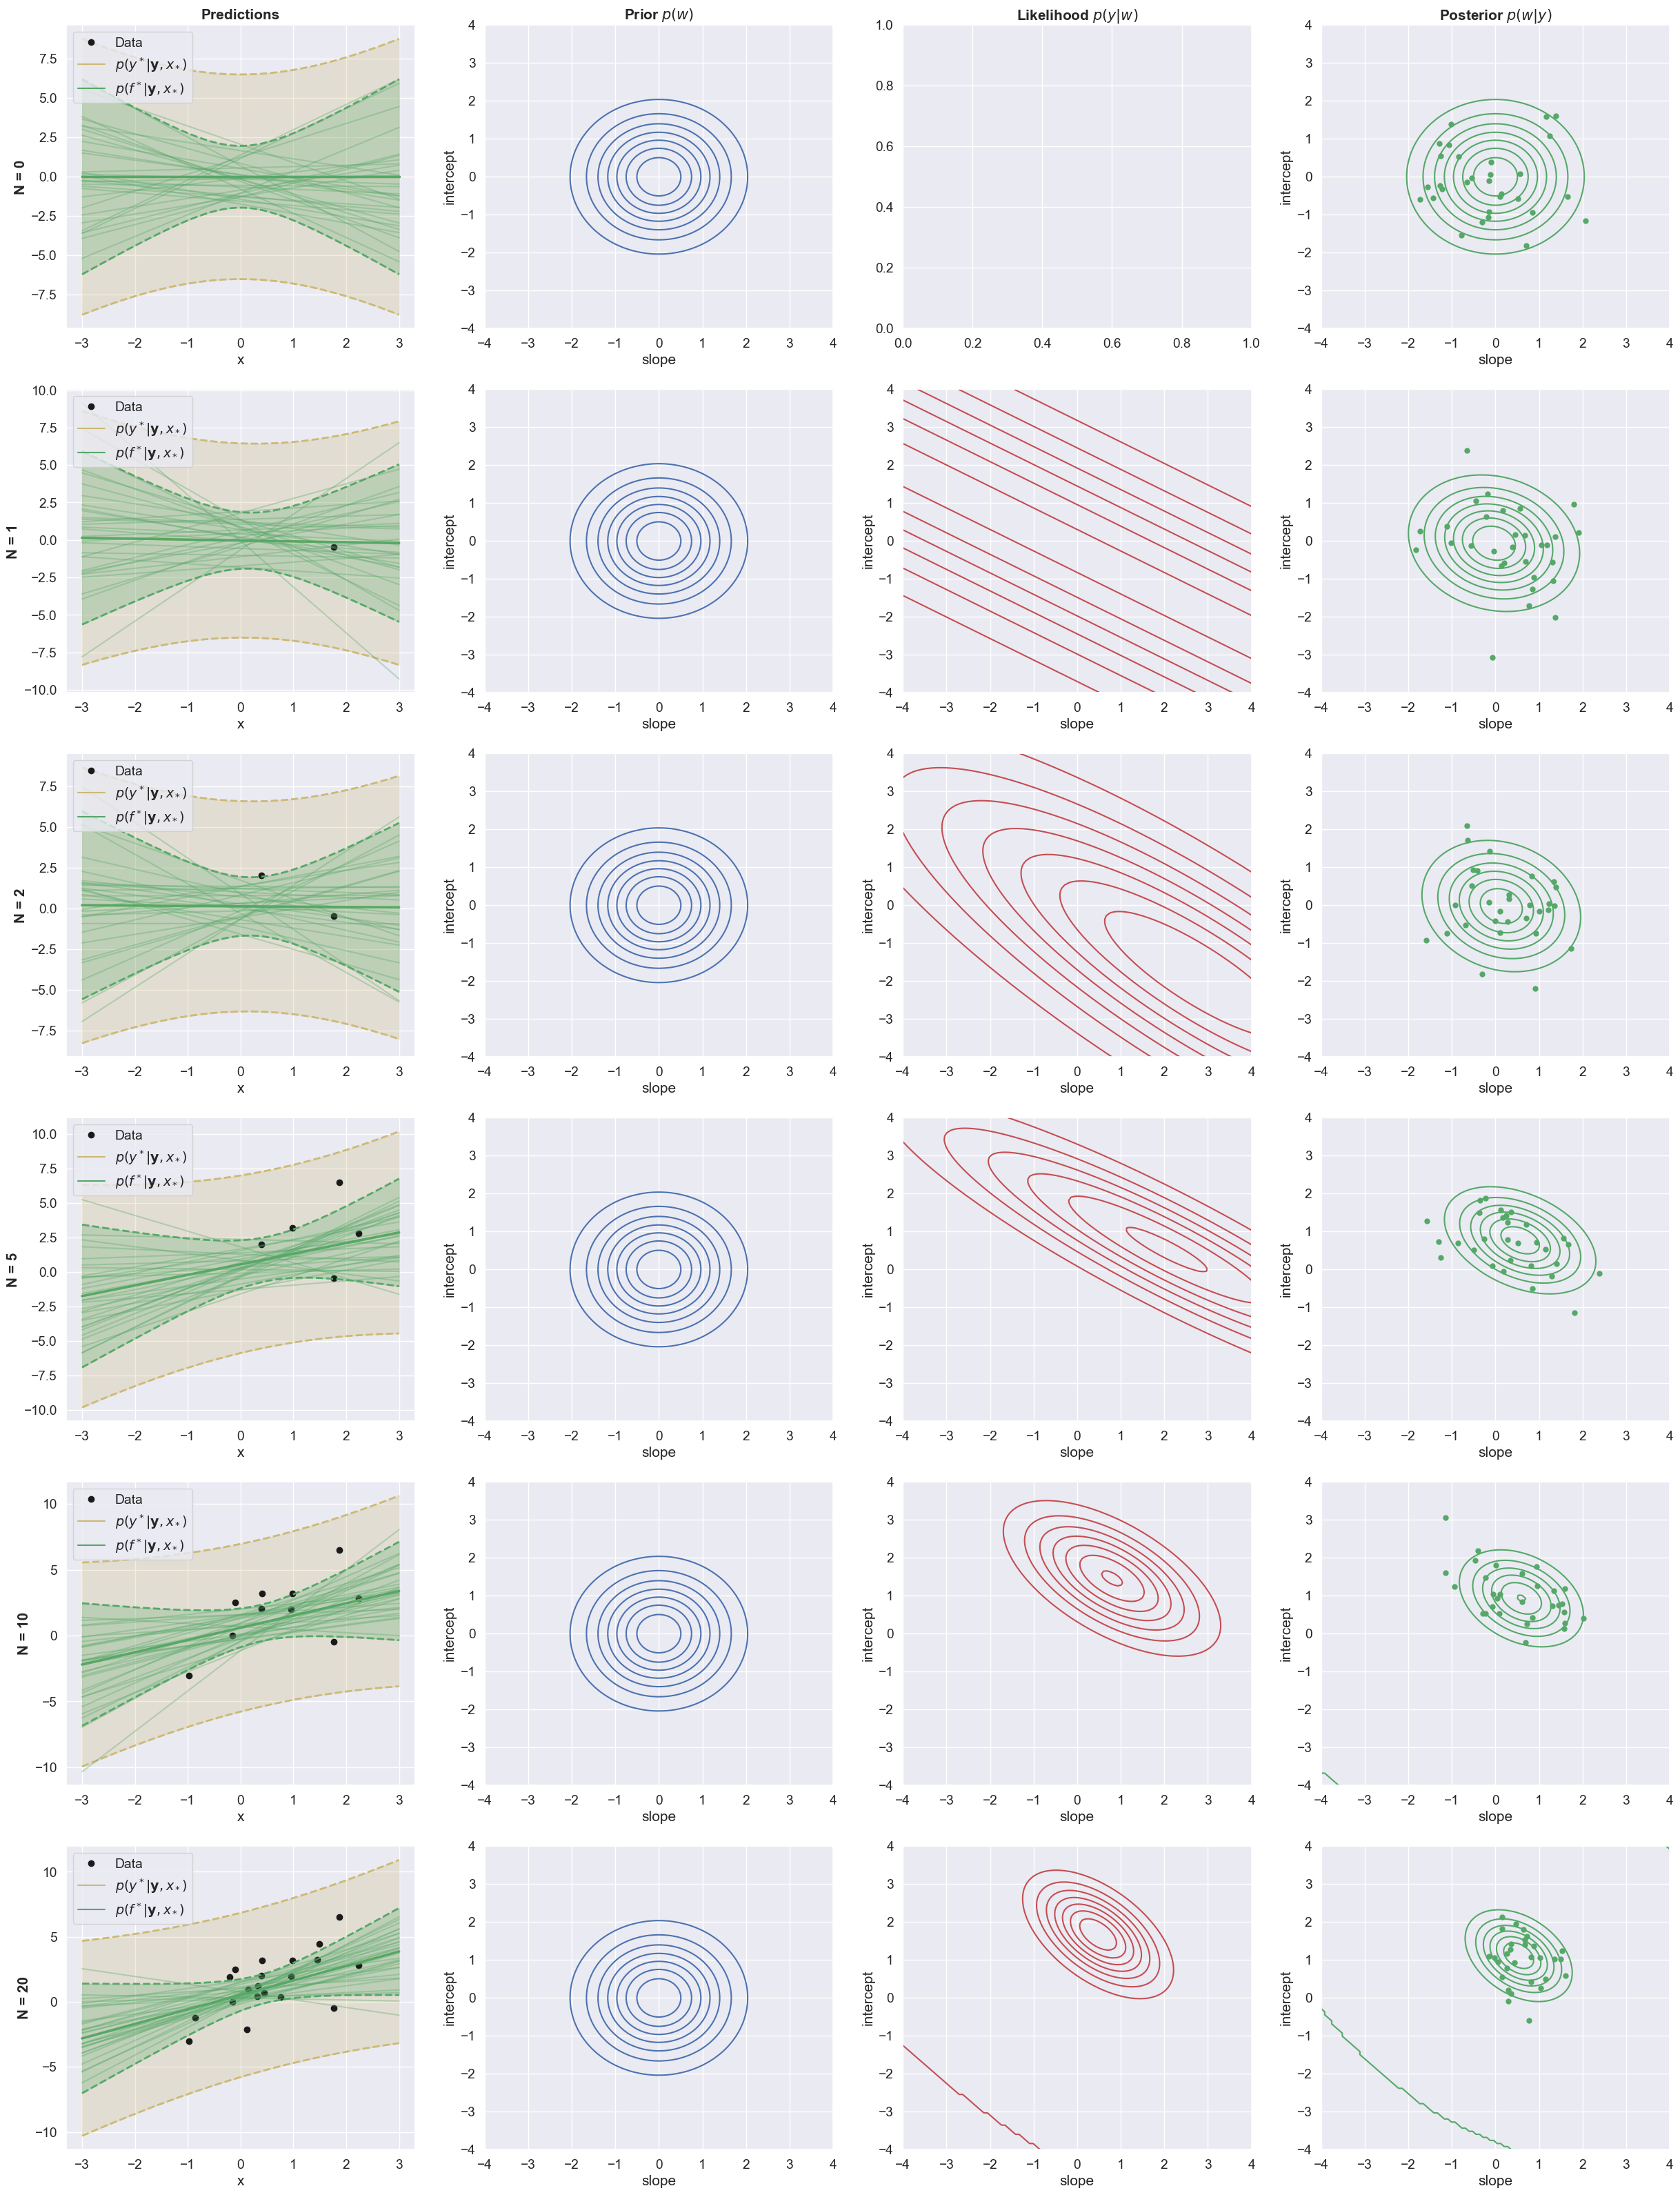

In [9]:
# helper function for visualizing predictions
def plot_predictions(ax, x, mu, var, color='r', visibility=0.5, label=None):
    lower, upper = mu - 1.96*jnp.sqrt(var), mu + 1.96*jnp.sqrt(var)
    ax.plot(x, mu, color=color, label=label)
    ax.plot(x, lower, color=color, linewidth=2, linestyle='--')
    ax.plot(x, upper, color=color, linewidth=2, linestyle='--')
    ax.fill_between(x.ravel(), lower.ravel(), upper.ravel(), color=color, alpha=visibility)
    ax.plot(x, mu, '-', color=color, label="", linewidth=2.5)
    
# fix seed
seed = 123
key = random.PRNGKey(seed)

# fix hyperparameters
alpha = 1
beta = 0.1




lambda_ = alpha / beta
print(f"lambda: {lambda_}")


# num posterior samples to plot
num_samples = 30

# design matrices
xpred = jnp.linspace(-3, 3, 50)[:, None]
Phi_train = design_matrix(xtrain)
Phi_pred = design_matrix(xpred)

fig, axes = plt.subplots(6, 4, figsize=(30, 40))    
for idx_n, n in enumerate([0, 1, 2, 5, 10, 20]):

    key, sample_key = random.split(key)
    
    # compute posterior of regression weights 
    model = BayesianLinearRegression(Phi_train[:n, :], ytrain[:n, :], alpha, beta)
    w_samples = model.generate_posterior_samples(sample_key, num_samples=num_samples)
    
    # split samples in a and b computes
    a_samples, b_samples = w_samples[:, 0], w_samples[:, 1]
    
    # computer posterior function values for f and y
    mu_f, var_f = model.predict_f(Phi_pred)
    mu_y, var_y = model.predict_y(Phi_pred)
    
    # plot in data space
    axes[idx_n, 0].plot(xtrain[:n, :], ytrain[:n, :], 'k.', markersize=12, label='Data')
    plot_predictions(axes[idx_n, 0], xpred, mu_y, var_y, visibility=0.25, color='y', label='$p(y^*|\\mathbf{y}, x_*)$')
    plot_predictions(axes[idx_n, 0], xpred, mu_f, var_f, visibility=0.25, color='g', label='$p(f^*|\\mathbf{y}, x_*)$')
    axes[idx_n, 0].set_ylabel('N = %d' % n, fontweight='bold')    
    for i, (ai, bi) in enumerate(zip(a_samples, b_samples)):
        axes[idx_n, 0].plot(xpred, predict(xpred, ai, bi), 'g-', alpha=0.35)
        
    axes[idx_n, 0].legend(loc='upper left')
    axes[idx_n, 0].set(xlabel='x')
    
    # plot prior
    plot_distribution(axes[idx_n, 1], xtrain[:n, :], ytrain[:n, :], density_fun=log_prior, color='b')
    
    # plot likelihood
    if n > 0:
        plot_distribution(axes[idx_n, 2], xtrain[:n, :], ytrain[:n, :], density_fun=log_likelihood, color='r')
        
    # plot posterior
    plot_distribution(axes[idx_n, 3], xtrain[:n, :], ytrain[:n, :], density_fun=log_posterior, color='g')
    axes[idx_n, 3].plot(a_samples, b_samples, 'g.', markersize=10)
        
    
axes[0, 0].set_title('Predictions', fontweight='bold');
axes[0, 1].set_title('Prior $p(w)$', fontweight='bold');
axes[0, 2].set_title('Likelihood $p(y|w)$', fontweight='bold');
axes[0, 3].set_title('Posterior $p(w|y)$', fontweight='bold');

In the figure above, the first column shows the data as well as the predictive distribution with 95% intervals. Each of the green lines corresponds to the function $f(x)$ for different posterior samples for $\mathbf{w}$. The columns 2, 3, and 4 show the prior, likelihood and posterior, respectively. Study the code and the plots above and answer the following questions:

**Task 3.2**: What happens to prior, likelihood and posterior as the number of samples $N$ increases? [**Discussion question**]



**Task 3.3**: What happens to the predictions if you keep $\beta = \frac{3}{4}$ and increase $\alpha$, e.g. to $\alpha = 100$ or $\alpha = 1000$? Why? [**Discussion question**]



**Task 3.4**: Set $\alpha$ to $\alpha = 1$ again. What happens if you decrease $\beta$, e.g. to $\beta = 0.1$? Why? [**Discussion question**]


**Task 3.5**: The variance of the predictive distribution $p(y_*|\mathbf{y}, \mathbf{x}_*)$ contains two components. Describe the two components in your own words and relate them to epistemic and aleatoric uncertainty. [**Discussion question**]


**Task 3.6**: As we get more and more data, the variance of the posterior distribution of $\mathbf{w}$ goes to zero. What happens to the variance of $p(y_*|\mathbf{y}, \mathbf{x}_*)$, $p(y^*|\mathbf{x}^*, \mathbf{w})$, and $p(f_*|\mathbf{y}, \mathbf{x}_*)$ as $N$ increases? To answer this, fix $\alpha = \beta = 1$ and consider the point $x^* = 1$. Plot the following three variances: the posterior predictive variance of $y^*$, the conditional variance of $y^*$ given $\mathbf{w}$ and posterior variance of $f^*$ as a function as size of the training set, i.e. for $N = \left\lbrace 0, 1, 2, .., 30 \right\rbrace$. Compare the plots to your findings above.

Shape of the posterior covariance matrix: (2, 2)
Shape of the posterior mean: (2, 1)
Shape of the predictive mean: (1,)
Shape of the predictive variance: (1,)
Shape of the predictive mean: (1,)
Shape of the predictive variance: (1,)
Shape of the posterior covariance matrix: (2, 2)
Shape of the posterior mean: (2, 1)
Shape of the predictive mean: (1,)
Shape of the predictive variance: (1,)
Shape of the predictive mean: (1,)
Shape of the predictive variance: (1,)
Shape of the posterior covariance matrix: (2, 2)
Shape of the posterior mean: (2, 1)
Shape of the predictive mean: (1,)
Shape of the predictive variance: (1,)
Shape of the predictive mean: (1,)
Shape of the predictive variance: (1,)
Shape of the posterior covariance matrix: (2, 2)
Shape of the posterior mean: (2, 1)
Shape of the predictive mean: (1,)
Shape of the predictive variance: (1,)
Shape of the predictive mean: (1,)
Shape of the predictive variance: (1,)
Shape of the posterior covariance matrix: (2, 2)
Shape of the poster

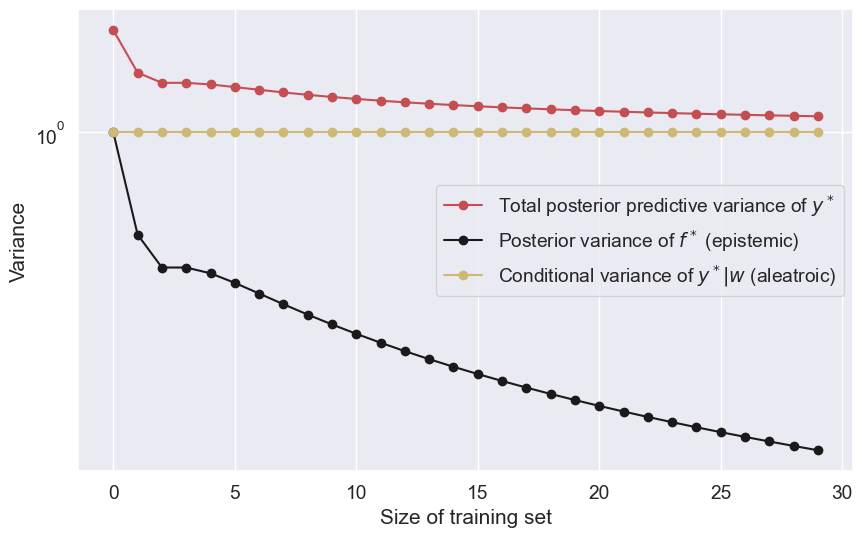

In [ ]:
alpha, beta = 1, 1
xstar = 1
Ns = jnp.arange(30)

#########################################################
# Insert your solution here
#########################################################
#################################################3
# End of solution
#################################################3


**Task 3.7**: Compute the prior mean and variance $f(x^*) = \phi(x^*)^T \bm{w} = a + b x^*$?*. Use the results to explain why the variance of both the posterior distribution of $f(x^*)$ and the variance of the posterior predictive distribution of $y(x^*)$ are smallest for $x^* = 0$ and both increase with $|x^*|$ for $N = 0$.




### Part 4:  Modelling the number of Airline passengers

Now we will apply Bayesian linear regression to model the number of monthly airline passengers (in thousands) in the period from 1949-1960. The values $(x_n, y_n)$ denote the time in months since the beginning of 1949 and the number monthly number of passangers, respectively.

So far, we have assumed that the hyperparameters $\alpha$ and $\beta$ of the model were fixed and known, but in practice, we almost always need to estimate them from data (or impose a prior on them and marginalize over them). As long as the number of hyperparameters is small, we can always rely on **cross-validation**. However, often the Bayesian framework offers a way to estimate these parameters based on the training set alone as follows.

The ***evidence approximation*** suggests that we can simply choose the hyperparameters $\alpha, \beta$ that maximizes the marginal likelihood of the model

$$\begin{align*}
\alpha^*, \beta^* = \arg\max\limits_{\alpha, \beta} \ln p(\mathbf{y}|\alpha, \beta),
\end{align*}$$

where $p(\mathbf{y}|\alpha, \beta) = \mathcal{N}(\mathbf{y}|\bm{0}, \alpha^{-1}\Phi^T \Phi + \beta^{-1}\mathbf{I})$ is the marginal likelihood of the model. This is also often referred to as **maximum likelihood type II estimation**. We could also easily "upgrade" this to **MAP type II estimation** by imposing a prior on $p(\alpha, \beta)$, i.e.

$$\begin{align*}
\alpha^*, \beta^* = \arg\max\limits_{\alpha, \beta} \ln p(\mathbf{y}|\alpha, \beta)p(\alpha, \beta).
\end{align*}$$

However, in this exercise we will use a uniform prior on $\alpha$ and $\beta$, i.e. $p(\alpha, \beta) \propto 1$, in which case the two estimators will give the same results.

Note that since both $\alpha >0 $ and $\beta > 0$ are strictly positive parameters (why?), we optimize $\tilde{\alpha} = \log \alpha$ and $\tilde{\beta} = \log \beta$ to enforce positivity on $\alpha$ and $\beta$.
We rely on **JaX** for gradient-based optimization using automatic differentiation and use the standard optimizer in scipy.


Let's load the data and plot the data.


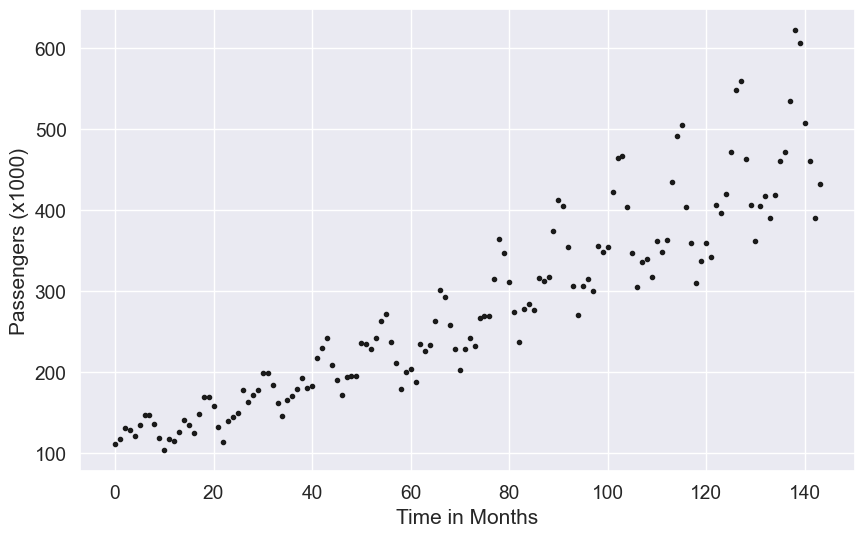

In [11]:
data = pd.read_csv('./AirPassengers.csv')
months = jnp.arange(0, len(data))[:, None]
passengers = jnp.array(data['#Passengers'].values)[:, None]

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(months, passengers, 'k.')
ax.set_xlabel('Time in Months')
ax.set_ylabel('Passengers (x1000)');

Since the number of passengers is a strictly positive quantity, we can often get better results by modelling the logarithm of the number of passengers instead.  We also split the dataset into a training and test set

N      = 144
Ntrain = 110
Ntest  = 34


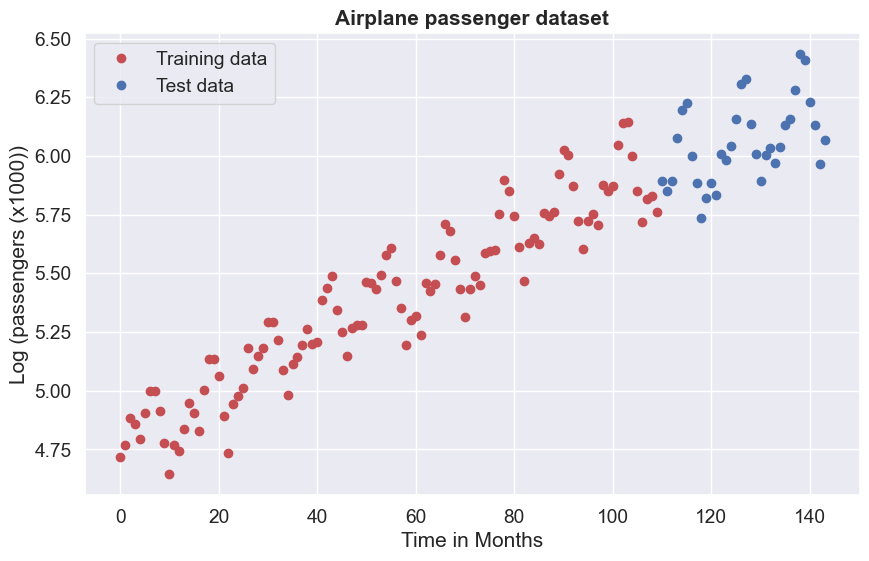

In [12]:
# log transform
y = jnp.log(passengers)

# split into  training and test
N = len(y)
Ntrain = 110
Ntest = N - Ntrain

x = jnp.arange(len(months))
xtrain = x[:Ntrain]
xtest = x[Ntrain:]

ytrain = y[:Ntrain]
ytest = y[Ntrain:]

print('N      = %d' % N)
print('Ntrain = %d' % Ntrain)
print('Ntest  = %d' % Ntest)


def plot_data(ax):
    ax.plot(xtrain, ytrain, 'ro', label='Training data')
    ax.plot(xtest, ytest, 'bo', label='Test data')
    ax.set_xlabel('Time in Months')
    ax.set_ylabel('Log (passengers (x1000))');
    ax.legend()
    ax.set_title('Airplane passenger dataset', fontweight='bold')

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_data(ax)
    



To measure the quality of the fit, we use the  **expected log predictive densities (ELPD)** for the training and test sets

\begin{align}
\text{ELPD} = \frac{1}{M}\sum_{i=1}^M \ln p(y^*_i|\mathbf{y}, \mathbf{x}^*_i),
\end{align}

where $p(y^*_i|\mathbf{y}, \mathbf{x}^*_i)$ is the posterior predictive distribution for observation $y^*_i$ in some dataset $\mathcal{D}_* = \left\lbrace \mathbf{x}^*_i, y^*_i \right\rbrace_{i=1}^M$. In contrast to simply reporting the mean square errors or similar, the ELPD also takes the uncertainty into account.

0.1758345 138.63112
Variance of y:  [0.00789003 0.00787591 0.00785696 0.00783389 0.00780783 0.00778022
 0.0077527  0.00772692 0.00770442 0.00768648 0.007674   0.00766739
 0.00766657 0.00767096 0.00767949 0.00769076 0.00770309 0.00771472
 0.00772394 0.00772925 0.0077295  0.00772395 0.00771239 0.00769516
 0.00767305 0.00764732 0.00761952 0.00759142 0.00756478 0.00754126
 0.00752223 0.00750868 0.00750111 0.00749953 0.00750341 0.00751175
 0.0075232  0.00753612 0.00754881 0.00755958 0.00756695 0.00756979
 0.00756739 0.00755952 0.0075465  0.00752911 0.00750855 0.00748632
 0.0074641  0.00744358 0.00742632 0.00741359 0.00740627 0.00740478
 0.00740899 0.00741831 0.00743166 0.00744762 0.00746455 0.00748069
 0.00749438 0.00750417 0.00750896 0.00750808 0.00750139 0.00748927
 0.00747257 0.00745256 0.00743082 0.00740908 0.00738907 0.00737239
 0.00736033 0.00735378 0.00735316 0.00735836 0.00736875 0.00738326
 0.00740046 0.00741868 0.00743617 0.00745127 0.00746252 0.00746882
 0.00746953 0.0074645  0.0

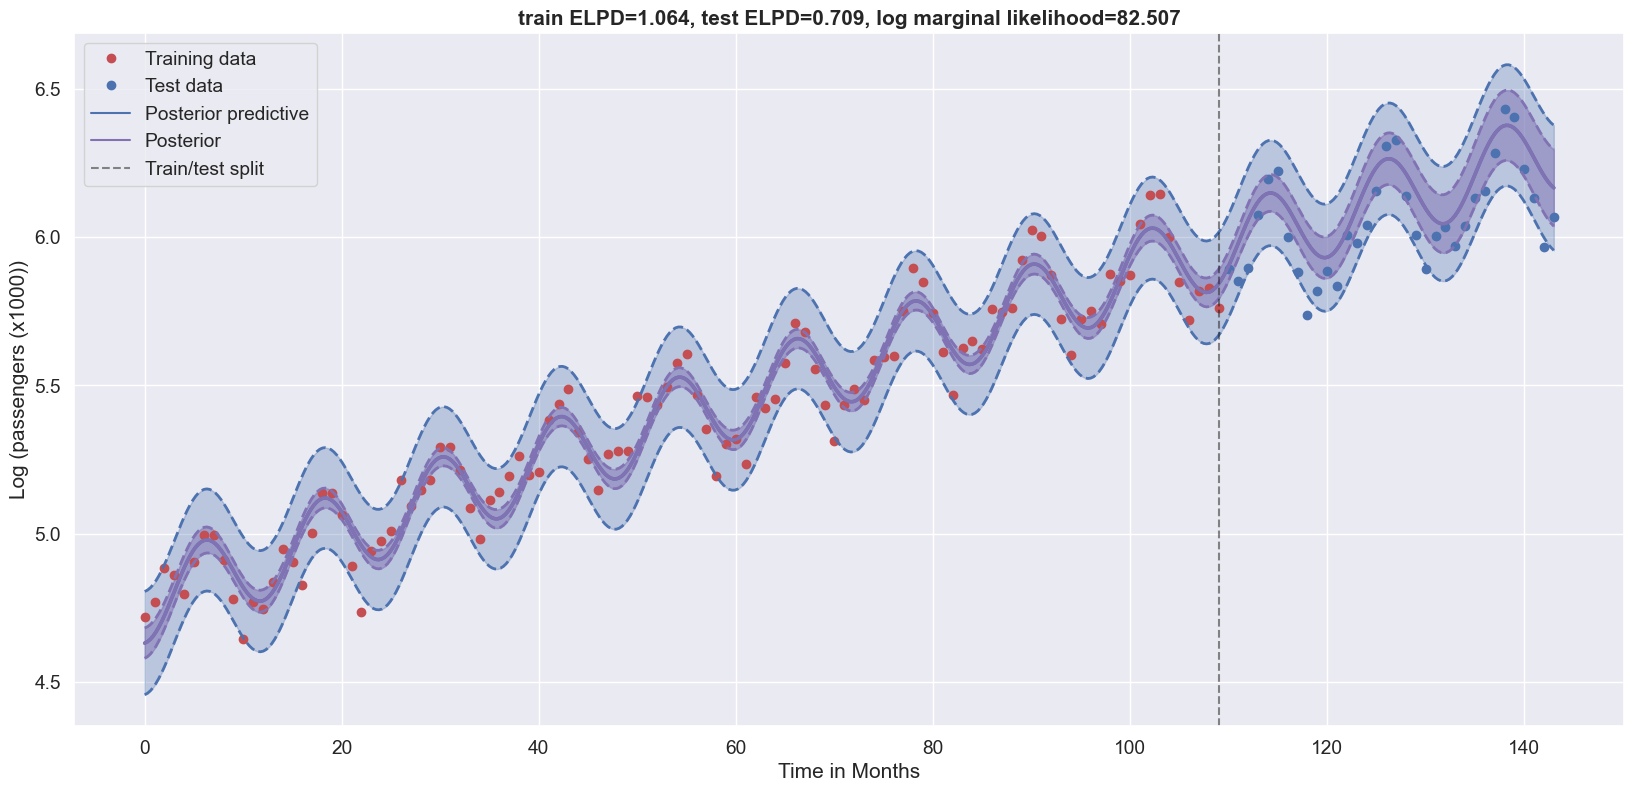

In [18]:
# we use the expected log predictive distribution as performance metric
def compute_elpd(y, mu, s2):
    """" y is a vector of observed values, and mu and s2 are the mean and variances of the posterior predictive distribution, respectively. """
    return jnp.mean(log_npdf(y.ravel(), mu.ravel(), s2.ravel()))

# Creates design matrix Phi based on input
def design_matrix(x):
    #return jnp.column_stack((jnp.ones(len(x)), x,   )) 
    #return jnp.column_stack((jnp.ones(len(x)), x, x**2))
    return jnp.column_stack((jnp.ones(len(x)), x,   x**2, jnp.cos(2*jnp.pi*x/12))) 

# prepare input data
xpred = jnp.linspace(0, 143, 500)
Phi_train = design_matrix(xtrain)
Phi_test = design_matrix(xtest)
Phi_pred = design_matrix(xpred)

# fit model
model = BayesianLinearRegression(Phi_train, ytrain, alpha=10, beta=1)
model.optimize_hyperparameters() 
print(model.alpha, model.beta)
logZ = model.log_marginal_likelihood

# make predictions for plotting
ypred_mu, ypred_s2 = model.predict_f(Phi_pred)
tpred_mu, tpred_s2 = model.predict_y(Phi_pred)

# make predictions for training and test set & evaluate performance metrics
ytrain_mu, ytrain_s2 = model.predict_y(Phi_train)
ytest_mu, ytest_s2 = model.predict_y(Phi_test)
train_elpd = compute_elpd(ytrain, ytrain_mu, ytrain_s2)
test_elpd = compute_elpd(ytest, ytest_mu, ytest_s2)

# plot
fig, ax = plt.subplots(1, 1, figsize=(20,9))
plot_data(ax)
plot_predictions(ax, xpred, tpred_mu, tpred_s2, color='b', label='Posterior predictive', visibility=0.3)
plot_predictions(ax, xpred, ypred_mu, ypred_s2, color='m', label='Posterior')
ax.set_title('train ELPD=%4.3f, test ELPD=%4.3f, log marginal likelihood=%4.3f' % (train_elpd, test_elpd, logZ), fontweight='bold');
ax.axvline(xtrain[-1], color='k', linestyle='--', alpha=0.5, label='Train/test split')
ax.legend()


**Task 4.1**: Run the code with $\alpha = 10$ and $\beta = 1$ as initial values. Comment on the quality of the fit. Note the values of the negative log likelihood for the training and test set.



**Task 4.2**: Estimate $\alpha, \beta$ by optimizing the marginal likelihood by uncommenting the line, which calls the function *optimize_hyperparameters()*. Report the estimates for $\alpha$ and $\beta$.



**Task 4.3**: Experiment with different linear models but the uncommenting different lines in the *design_matrix()* function. Comment on the train/test ELPDs as well as the marginal likelihood.


**Task 4.4**: Comment on uncertainty estimates for the training and test set.

**Task 4.5**: Compute and visualize the posterior and the posterior predictive distribution for the logarithm of the number of customers after 145 months?

For statistical models like $y_n = f(\mathbf{x}_n) + e_n$, we typically refer to $e_n$ as noise, but another way to think about $e_n$ is that it represent the part of the signal we cannot explain by the model $f(\mathbf{x}_n)$. 

**Task 4.6**: If you get hired by an airline company, and they asked you to provide a 95% credibility interval for the number of log passengers after 145, would you use the posterior distribution $p(f_*|y, x_*)$ or the posterior predictive distribution $p(y_*|y, x_*)$? and why?

**Task 4.7**: Compute the predictive distribution for the number of passengers instead of the logarithm of the number of passengers. 

- Hints: You can either using sampling techniques or you use the fact that exponentiating a Gaussian random variable is a Log-Normal distribution with closed-form moments. See more here: [https://en.wikipedia.org/wiki/Log-normal_distribution](https://en.wikipedia.org/wiki/Log-normal_distribution)